In [29]:
import os

import sagemaker
from sagemaker.pytorch import PyTorch

import numpy as np

## Upload Data

In [30]:
session = sagemaker.Session()

bucket = session.default_bucket()
s3_prefix = 'capstone/v1'

role = sagemaker.get_execution_role()

Couldn't call 'get_role' to get Role ARN from role name voclabs to get Role path.


In [32]:
data_dir = 'processed'
input_data = session.upload_data(path=data_dir, bucket=bucket, key_prefix=s3_prefix)

## Train the Model

In [33]:
output_path = f's3://{bucket}/{s3_prefix}/output'

estimator = PyTorch(
    source_dir='src',
    entry_point='train.py',
    role=role,
    framework_version='1.1.0',
    py_version='py3',
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    output_path=output_path,
    hyperparameters={
        'seed': 1,
        'batch-size': 512,
        'epochs': 10,
        'embedding-dim': 32,
        'num-lstm-layers': 1,
        'hidden-dims': '100',
        # vocab size from previous step + 2 for
        # out of vocab and empty
        'vocab-size': 10002
    }
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [34]:
estimator.fit({
    'training': os.path.join(input_data, 'test'),
    'eval': os.path.join(input_data, 'val')
})

ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: Could not assume role arn:aws:iam::281832773096:role/voclabs. Please ensure that the role exists and allows principal 'sagemaker.amazonaws.com' to assume the role.

In [ ]:
from sagemaker.tuner import HyperparameterTuner, CategoricalParameter, IntegerParameter

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name='ROC_AUC',
    objective_type='Minimize',
    max_jobs=20,
    max_parallel_jobs=3,
    metric_definitions={
        'Name': 'ROC_AUC',
        'Regex': 'roc_auc: (.*?);'
    },
    early_stopping_type='Auto',
    hyperparameter_ranges={
        'embedding-dim': CategoricalParameter([32, 64]),
        'num-lstm-layers': IntegerParameter(1, 4),
        'hidden-dims': CategoricalParameter(['100', '100 64', '100 64 32', '100 64 32 16'])
    }
)

tuner.fit({
    'training': os.path.join(input_data, 'test'),
    'eval': os.path.join(input_data, 'val')
})
tuner.wait()

In [ ]:
tuner.best_training_job()

## Evaluate

In [ ]:
# Deploy my estimator to a SageMaker Endpoint and get a Predictor
predictor = estimator.deploy(
    instance_type='ml.m4.xlarge',
    initial_instance_count=1
)

In [10]:
# recover when the notebook crashes during training.....
from sagemaker.pytorch.model import PyTorchModel

model_artifact_location = 's3://sagemaker-us-east-1-281832773096/capstone/v1/output/sagemaker-pytorch-2021-03-23-23-22-08-640/output/model.tar.gz'

model = PyTorchModel(
    model_data=model_artifact_location,
    role=role,
    source_dir='src',
    entry_point='train.py',
    framework_version='1.1.0',
    py_version='py3',
)

predictor = model.deploy(
    instance_type='ml.m4.xlarge',
    initial_instance_count=1
)

-------------!

In [ ]:
from importlib import reload  
import src.utils
reload(src.utils)
import joblib
with open('processed/vocab.joblib', 'rb') as f:
    vocab = joblib.load(f)

sentence = 'You bad, you are the worst person alive!!!'
input_vec = src.utils.encode_single_input(sentence, vocab)
response = predictor.predict(input_vec)

In [24]:
import numpy as np
predictor.predict(np.array([X[0]]))

array([[3.8925072e-07, 7.7192180e-07, 3.1521043e-07, 1.1656718e-07,
        1.1316162e-09, 1.9014143e-06]], dtype=float32)

In [31]:
import joblib
with open('processed/val/data.joblib', 'rb') as f:
    val_data = joblib.load(f)
    
y_true = val_data[:, :6]
X = val_data[:, 6:]

y_pred = np.array([predictor.predict(chunk) for chunk in np.split(X, range(100, X.shape[0], 100))])
y_pred = np.concatenate(y_pred, axis=0)
y_pred_class = y_pred.round()

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable rint method

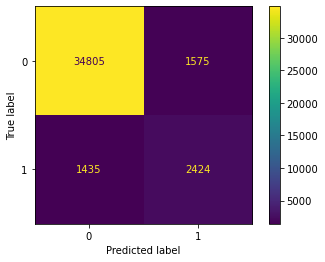

In [46]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay
)

disp = ConfusionMatrixDisplay(confusion_matrix(y_true[:, 0], y_pred_class[:, 0]))
disp.plot()

In [47]:
dir(disp)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'ax_',
 'confusion_matrix',
 'display_labels',
 'figure_',
 'im_',
 'plot',
 'text_']

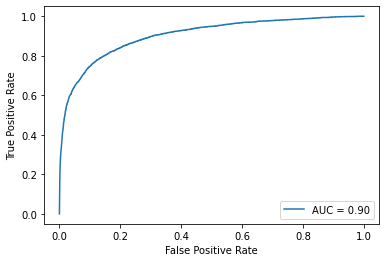

In [42]:
fpr, tpr, thresholds = roc_curve(y_true[:, 0], y_pred[:, 0])
roc_auc = auc(fpr, tpr)
disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

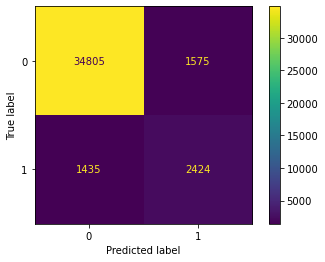

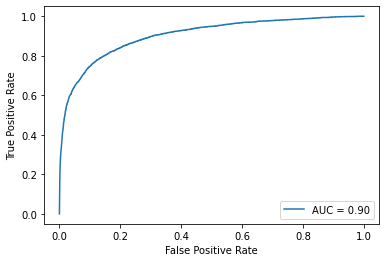

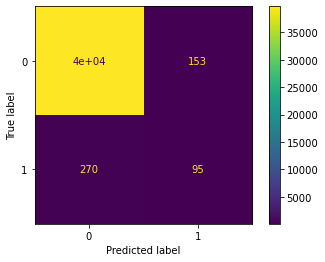

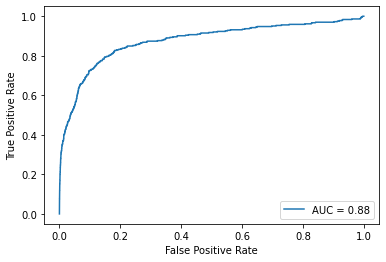

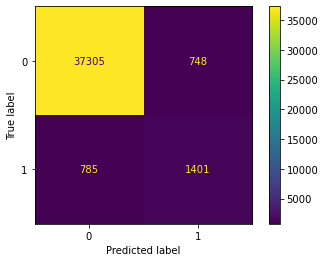

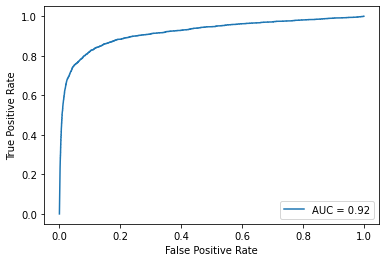

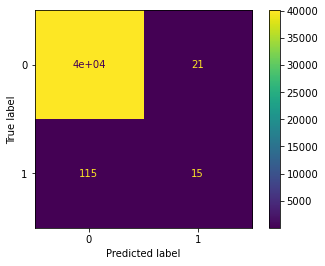

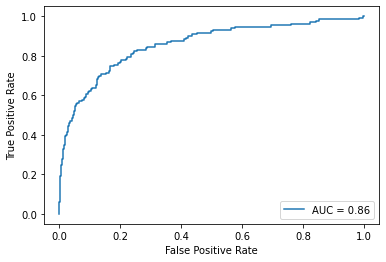

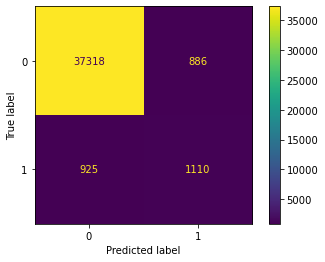

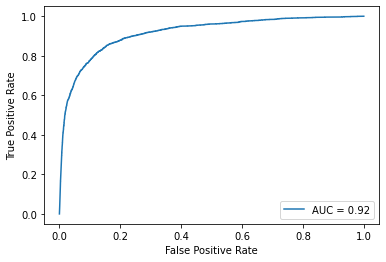

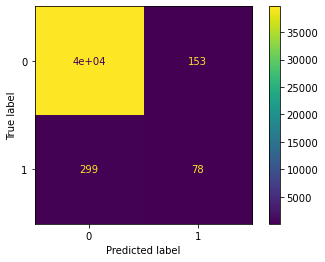

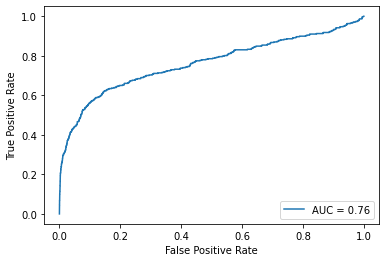

In [53]:
asset_dir = 'results/v1/'
os.makedirs(asset_dir, exist_ok=True)

for i in range(6):
    filename = os.path.join(asset_dir, f'confusion_matrix_{i}.png')
    ConfusionMatrixDisplay(confusion_matrix(y_true[:, i], y_pred_class[:, i])).plot().figure_.savefig(filename)
    
    filename = os.path.join(asset_dir, f'roc_curve_{i}.png')
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot().figure_.savefig(filename)

In [54]:
predictor.delete_endpoint()

In [79]:
import pandas as pd

full_df = pd.read_csv('data/raw_combined.csv')
_, encoded_text = src.utils.encode_text(
    full_df, 
    use_cache=True,
    max_length=500,
    vocab_length=10000
)

In [99]:
# why is class 6, identity hate, so poorly performing?
# pick a few false positives and false negatives

from importlib import reload  
import src.utils
reload(src.utils)

mask = (y_pred[:, 5] < 0.5) & (y_true[:, 5] == 1)
false_neg = X[mask]
false_neg_pred = y_pred[mask]
false_neg_true = y_true[mask]

idx = 10
for i, row in enumerate(encoded_text):
    if np.equal(row, false_neg[idx]).all():
        print(full_df.iloc[i]['comment_text'])
        break
print()
print(' '.join(src.utils.decode_text(false_neg[idx], vocab)))
print(false_neg_pred[idx])
print(false_neg_true[idx])

.

WTF?
Why the fuck do you think that i vandalized the nigger, Oklahoma City Bombing, and prohibition pages? I haven't even been on any of those pages. Thank you douschebag for getting my editing privilages revoked. You are a prick

wtf fuck think vandalized nigger oklahoma city bombing prohibition page havent even page thank <mvt> getting editing <mvt> revoked prick
[9.9999940e-01 1.5343325e-02 9.9999976e-01 4.3093492e-05 9.9999988e-01
 7.3052738e-03]
[1 0 1 0 1 1]


Wow, these comments are awful. But importantly there are lots of misspelled words here. Using a spelling correction tool in the preprocessing would likely help a lot.